In [24]:
import pandas as pd
import numpy as np
import geopandas as gpd
import random

1. Load the Heatseek Data into a GeoPandas GeoDataFrame

2. Load a standard map of NYC from gpd.datasets

3. Convert the csv's Mercator projection (lat/long) to a standard map projection

In [2]:
df = pd.read_csv('heatseek_geocoded.csv', index_col = 0)
heatseek = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
heatseek.crs = "EPSG:4326"
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
hs_new = heatseek.to_crs(nyc.crs)

Import some road data to verify that the data is being fuzzed appropriately and logically.

In [13]:
file_path = gpd.read_file('road.geojson')
roads = gpd.GeoDataFrame(file_path)
roads.crs = "EPSG:4326"
nyc_roads = roads.to_crs(nyc.crs)

Here's what a subsection of the original data looks like when mapped out:

(220000.0, 260000.0)

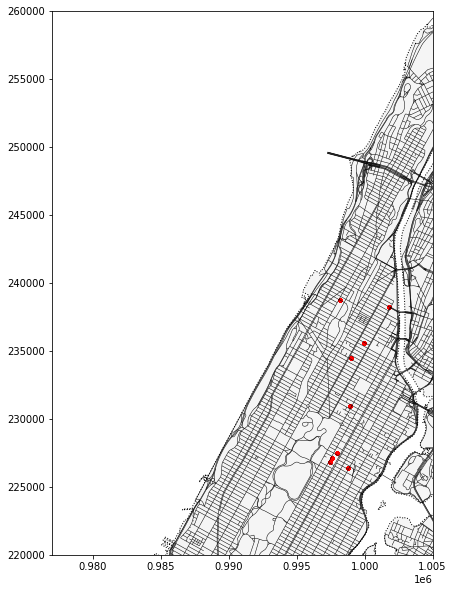

In [22]:
ax = nyc.plot(figsize=(10,10), color='whitesmoke', linestyle=':', edgecolor='k')
nyc_roads.plot(ax=ax, color='black', linewidth=.5)
hs_new.plot(markersize=10, ax=ax, color='r')
ax.set_xlim([977000, 1005000])
ax.set_ylim([220000, 260000])

Doing some snooping in Google Earth it looks like 0.0005 degrees in latitude is approximately 500 meters.

By applying random number generator to add/subtract somewhere between 0.0005 and 0.0005 on both latitude and longitude, the general area is maintained but also privacy is achieved. Also need to slice the dataset by latitude to ensure all readings are offset by the same amount.

Sidenote: An issue could arise where locations on the shore are fuzzed into the sea.

In [97]:
df['lat_fuzz'] = np.zeros(len(list(df.index)))
df['lon_fuzz'] = np.zeros(len(list(df.index)))

for lat in df['lat'].unique():
    lat_rando = (random.randint(0,100)/100000 * random.choice((1,-1)))
    lon_rando = (random.randint(0,100)/100000 * random.choice((1,-1)))
    for idx in df[df['lat']==lat].index:
        df['lat_fuzz'][idx] = df['lat'][idx] + lat_rando
        df['lon_fuzz'][idx] = df['lon'][idx] + lon_rando

/Users/ryaniyer/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ryaniyer/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Looking at a given sensor, the displacement seems consistent:

In [105]:
df[df['sensor_id']=='feather0090'].head(3)

,user_id,address,zip_code,apartment,sensor_id,bbl,temp,created_at,outdoor_temp,violation,add_full,lat,lon,geometry,lat_fuzz,lon_fuzz
0,381.0,124 E 176th St,10453.0,6J,feather0090,2.028260e+09,66,2019-01-30 23:58:43,11.0,True,"124 E 176th St, New York City, New York, USA",40.847928,-73.908931,POINT (-73.90982 40.84697),40.846968,-73.909821
28,381.0,124 E 176th St,10453.0,6J,feather0090,2.028260e+09,66,2019-01-30 22:58:43,16.0,True,"124 E 176th St, New York City, New York, USA",40.847928,-73.908931,POINT (-73.90982 40.84697),40.846968,-73.909821
56,381.0,124 E 176th St,10453.0,6J,feather0090,2.028260e+09,67,2019-01-30 21:58:42,21.0,True,"124 E 176th St, New York City, New York, USA",40.847928,-73.908931,POINT (-73.90982 40.84697),40.846968,-73.909821


In [99]:
heatseek_fuzz = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_fuzz, df.lat_fuzz))
heatseek_fuzz.crs = "EPSG:4326"
heatseek_fuzz = heatseek_fuzz.to_crs(nyc.crs)

The offset looks pretty good. Each market is off by at most 2 blocks, and none are in the exact same building.

(225000.0, 240000.0)

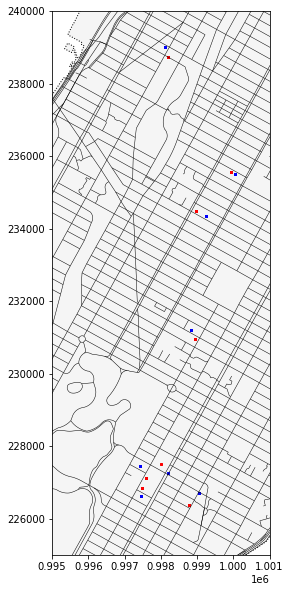

In [101]:
ax = nyc.plot(figsize=(10,10), color='whitesmoke', linestyle=':', edgecolor='k')
nyc_roads.plot(ax=ax, color='black', linewidth=.5)
hs_new.plot(markersize=2, ax=ax, color='r')
heatseek_fuzz.plot(markersize=2, ax=ax, color='b')
#zoom in on upper-east side and harlem area:
ax.set_xlim([995000, 1001000])
ax.set_ylim([225000, 240000])

Warning: Running below cell will create a new file.

In [104]:
df.to_csv('HS_Fuzz_Geocoded.csv')